In [1]:
!echo $CONDA_DEFAULT_ENV
import os

# Print the current working directory
print(os.getcwd())

llasa
/workspace/LLaSA/model/segmentation


In [4]:
!pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 7.2 MB/s eta 0:00:00a 0:00:01


In [4]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [15]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_configs/sam2_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [16]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

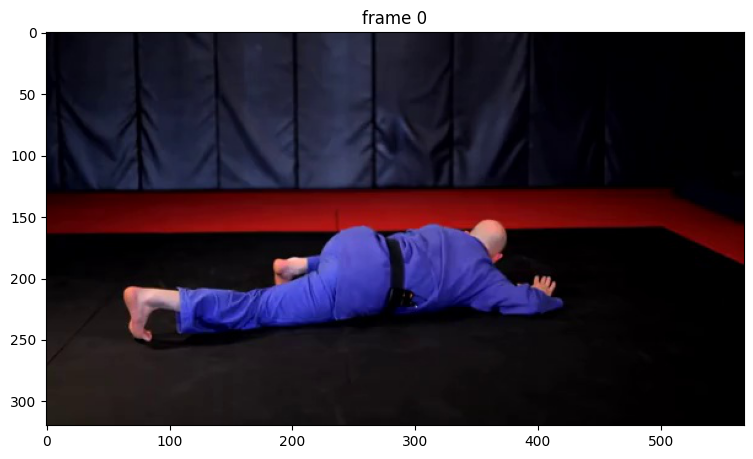

In [51]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "/workspace/LLaSA/dataset/A2D/clips320jpeg/_4JOpIKy0rA"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [52]:

def save_video_frames(video_path):
    # Extract the base name of the video file (e.g., '__KkKB4wzrY.mp4')
    video_name = os.path.basename(video_path)
    
    # Extract the directory path (e.g., 'Release/clips320H')
    base_dir = os.path.dirname(video_path)
    
    # Create the corresponding output directory path (e.g., 'Release/clips320jpeg/__KkKB4wzrY')
    output_dir = os.path.join(base_dir.replace('clips320H', 'clips320jpeg'), os.path.splitext(video_name)[0])
    
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize frames generator
    frames_generator = sv.get_video_frames_generator(video_path)
    
    # Initialize image sink with the output directory and naming pattern
    sink = sv.ImageSink(
        target_dir_path=output_dir,
        image_name_pattern="{:05d}.jpeg"
    )
    
    # Process each frame
    with sink:
        for i, frame in enumerate(frames_generator, start=1):
            # Construct the file path for each frame
            frame_path = os.path.join(output_dir, f"{i:05d}.jpeg")
            
            # Check if the frame already exists; if so, skip saving
            if os.path.exists(frame_path):
                print(f"Frame {frame_path} already exists. Skipping.")
                continue
            
            # Save the frame
            sink.save_image(frame)
            print(f"Saved frame to {frame_path}")

In [80]:
inference_state = predictor.init_state(video_path=video_dir)


frame loading (JPEG):  18%|█▊        | 16/91 [00:00<00:04, 15.83it/s]

frame loading (JPEG): 100%|██████████| 91/91 [00:05<00:00, 16.82it/s]


In [81]:
predictor.reset_state(inference_state)


In [82]:
def inference_video(self, video_path, interact_frame, mask):
    # video path must be a directory that contains all jpeg files of the video 
    # mask format: 2d (w,h) torch.bool
    inference_state = self.predictor.init_state(video_path = video_path)
    self.predictor.reset_state(inference_state)

    ann_obj_id = 1

    _, out_obj_ids, out_mask_logits = self.predictor.add_new_mask(
        inference_state = inference_state,
        frame_idx = interact_frame,
        obj_id = ann_obj_id,
        mask = mask
    )
    

In [46]:
mask_file = '/workspace/LLaSA/dataset/A2D/Annotations/col/_4JOpIKy0rA/00030.png'

In [77]:
import numpy as np
from PIL import Image
import torch
import random

def load_mask_to_tensor(file_path):
    # Load the image using PIL
    image = Image.open(file_path).convert("RGB")  # Ensure it's in RGB mode
    
    # Convert the image to a NumPy array
    image_np = np.array(image)
    
    # Find unique colors in the mask
    unique_colors = np.unique(image_np.reshape(-1, image_np.shape[2]), axis=0)
    
    # If there are more than two colors, pick one randomly for the mask
    if len(unique_colors) > 2:
        print(f'there are {unique_colors} colors, pick one of them')
        selected_color = unique_colors[random.randint(0, len(unique_colors) - 1)]
    else:
        # If only one or two colors, just use the first unique color
        selected_color = unique_colors[0]
    
    # Create a binary mask based on the selected color
    binary_mask = np.all(image_np == selected_color, axis=-1)

    # Invert the mask
    binary_mask = np.logical_not(binary_mask)

    # Convert the binary mask to a PyTorch tensor of dtype bool
    mask_tensor = torch.tensor(binary_mask, dtype=torch.bool)
    
    return mask_tensor


def get_bounding_box(mask_tensor):
    # Convert the mask tensor to a NumPy array (if it isn't already)
    mask_np = mask_tensor.cpu().numpy()

    # Get the coordinates of the non-zero (True) elements in the mask
    y_coords, x_coords = np.where(mask_np)

    # Compute the bounding box coordinates
    x_min = np.min(x_coords)
    x_max = np.max(x_coords)
    y_min = np.min(y_coords)
    y_max = np.max(y_coords)

    return np.float32((x_min, y_min, x_max, y_max))


In [78]:
mask_tensor = load_mask_to_tensor(mask_file)
bbox = get_bounding_box(mask_tensor)
print(bbox)

[ 60. 147. 420. 254.]


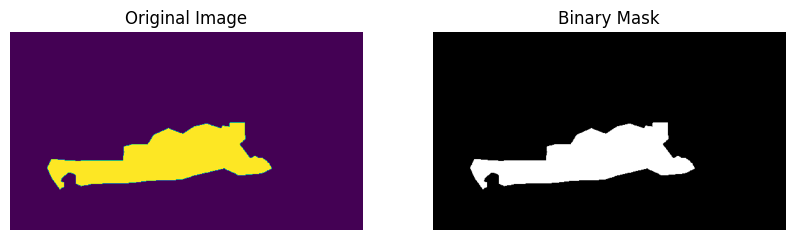

In [62]:
# Convert the PyTorch tensor to a NumPy array for visualization
mask_np = mask_tensor.cpu().numpy()

# Plot the original image and the binary mask side by side
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(mask_np)
plt.title("Original Image")
plt.axis('off')

# Binary mask
plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap='gray')
plt.title("Binary Mask")
plt.axis('off')

plt.show()

/workspace/LLaSA/model/segmentation/sam2/sam2_video_predictor.py:873: UserWarning: cannot import name '_C' from 'sam2' (/workspace/LLaSA/model/segmentation/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


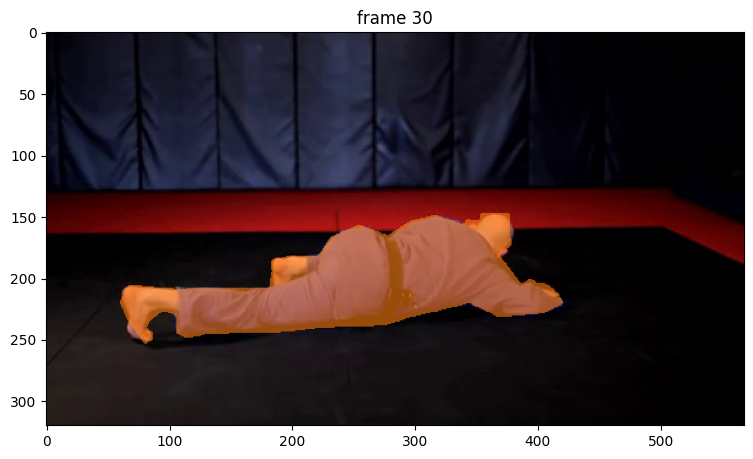

In [63]:
labels = np.array([1], np.int32)
ann_frame_idx = 30  # the frame index we interact with
ann_obj_id = 1 

_, out_obj_ids, out_mask_logits = predictor.add_new_mask(
    inference_state=inference_state,
    frame_idx=30,
    obj_id=1,
    mask=mask_tensor,
)


# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))

show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

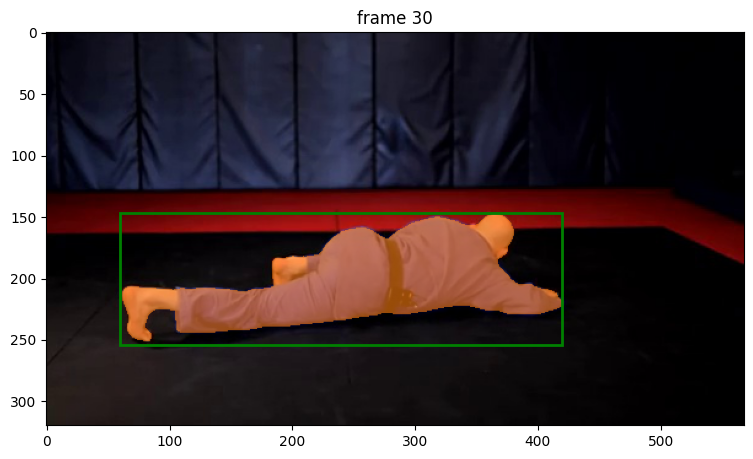

In [83]:
ann_frame_idx = 30  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a box at (x_min, y_min, x_max, y_max) = (300, 0, 500, 400) to get started

_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=bbox,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(bbox, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

/workspace/LLaSA/model/segmentation/sam2/sam2_video_predictor.py:873: UserWarning: cannot import name '_C' from 'sam2' (/workspace/LLaSA/model/segmentation/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


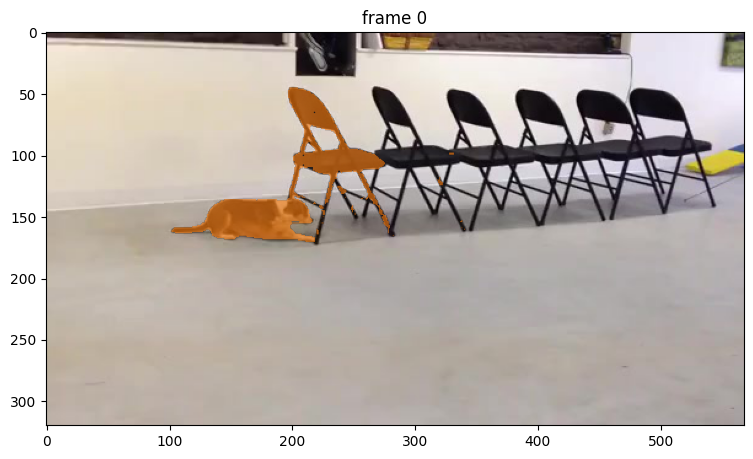

In [24]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[210, 350]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

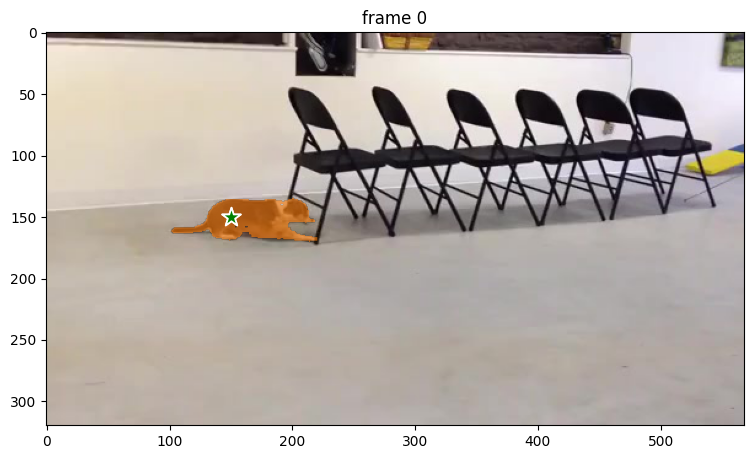

In [27]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd positive click at (x, y) = (250, 220) to refine the mask
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([[150, 150], [150, 150]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

propagate in video:   0%|          | 0/61 [00:00<?, ?it/s]/workspace/LLaSA/model/segmentation/sam2/sam2_video_predictor.py:873: UserWarning: cannot import name '_C' from 'sam2' (/workspace/LLaSA/model/segmentation/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 31/31 [00:01<00:00, 15.87it/s]


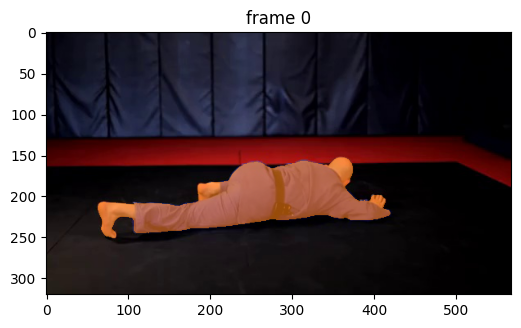

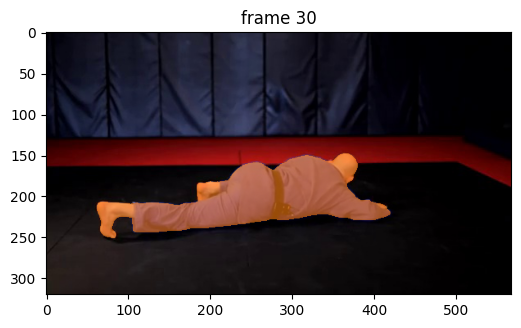

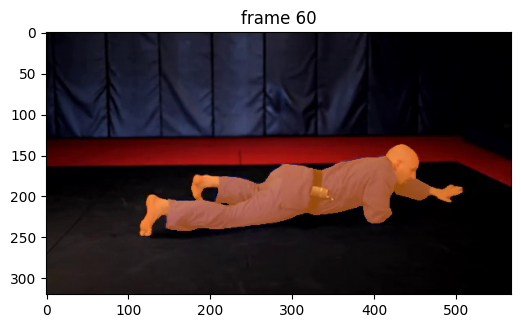

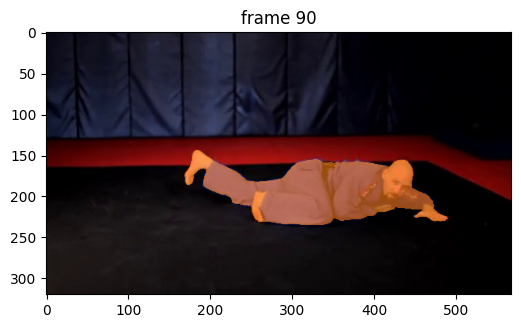

In [104]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, reverse=True):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

IndexError: list index out of range

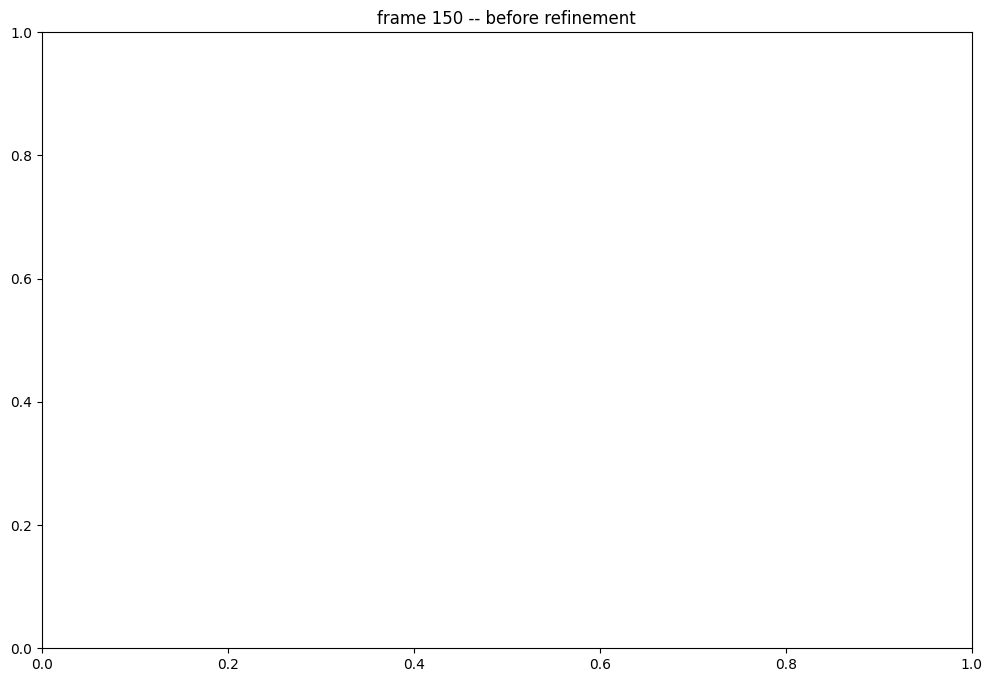

In [66]:
ann_frame_idx = 150  # further refine some details on this frame
ann_obj_id =   # give a unique id to the object we interact with (it can be any integers)

# show the segment before further refinement
plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx} -- before refinement")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_mask(video_segments[ann_frame_idx][ann_obj_id], plt.gca(), obj_id=ann_obj_id)

# show the segment after the further refinement
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx} -- after refinement")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id)

IndexError: list index out of range

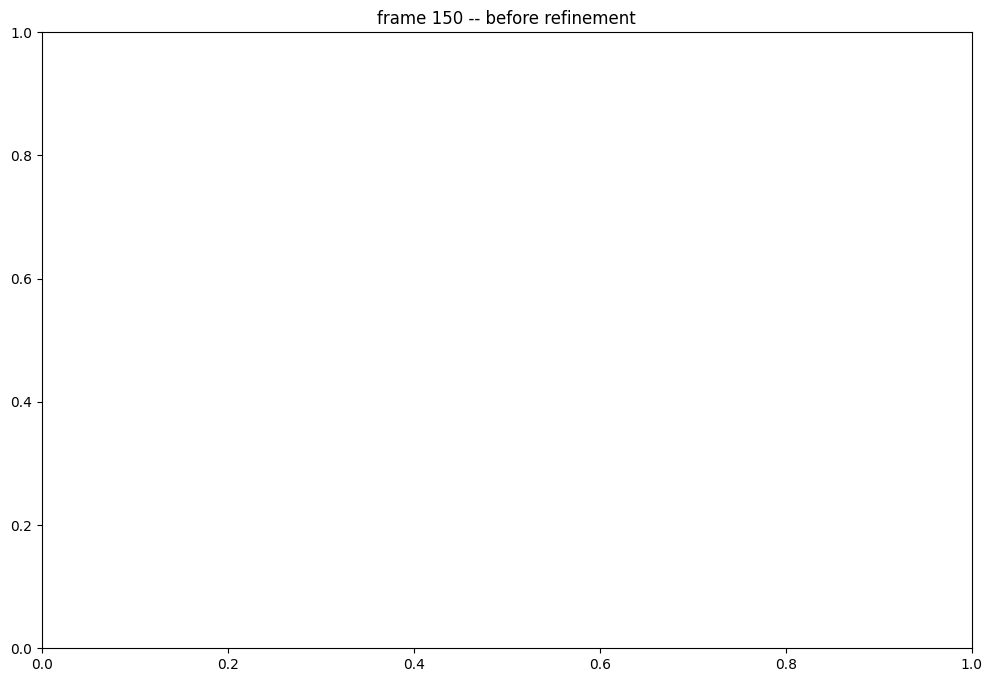

In [67]:
ann_frame_idx = 150  # further refine some details on this frame
ann_obj_id = 30  # give a unique id to the object we interact with (it can be any integers)

# show the segment before further refinement
plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx} -- before refinement")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_mask(video_segments[ann_frame_idx][ann_obj_id], plt.gca(), obj_id=ann_obj_id)

# Let's add a negative click on this frame at (x, y) = (82, 415) to refine the segment
points = np.array([[82, 415]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([0], np.int32)
_, _, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the segment after the further refinement
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx} -- after refinement")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id)

propagate in video:   0%|          | 0/61 [00:00<?, ?it/s]/workspace/LLaSA/model/segmentation/sam2/sam2_video_predictor.py:873: UserWarning: cannot import name '_C' from 'sam2' (/workspace/LLaSA/model/segmentation/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 61/61 [00:03<00:00, 15.60it/s]


IndexError: tuple index out of range

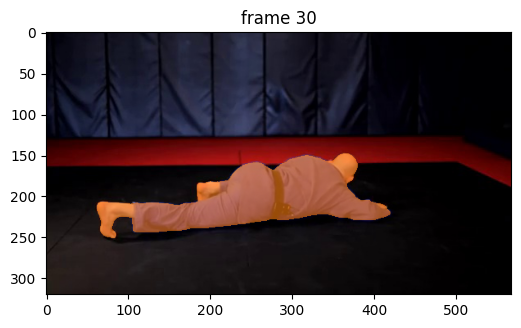

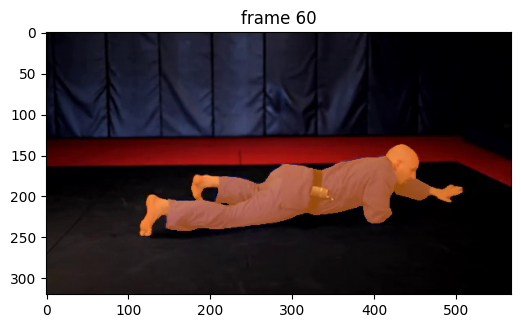

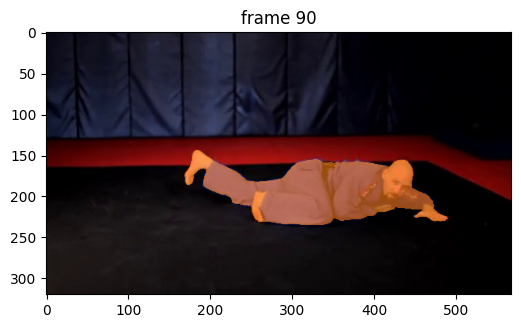

In [94]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results

# Dictionary to store the outputs
outputs = {}

# Hook function to capture the output
def hook_fn(module, input, output):
    outputs['sam_mask_decoder_transformer'] = output

# Assuming predictor is an instance of SAM2VideoPredictor
# Register the hook on the TwoWayTransformer module within sam_mask_decoder
hook_handle = predictor.sam_mask_decoder.transformer.register_forward_hook(hook_fn)


for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(30, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)


# Access the output from the transformer
transformer_output = outputs.get('sam_mask_decoder_transformer')

# Print the shape of the captured output for verification
if transformer_output is not None:
    print(f"Transformer output shape: {transformer_output[3].shape}")

# Remove the hook if it's no longer needed
hook_handle.remove()

In [99]:
print(transformer_output[0].shape, transformer_output[1].shape)

torch.Size([1, 8, 256]) torch.Size([1, 4096, 256])


In [103]:
print(predictor)

SAM2VideoPredictor(
  (image_encoder): ImageEncoder(
    (trunk): Hiera(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 144, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      )
      (blocks): ModuleList(
        (0-1): 2 x MultiScaleBlock(
          (norm1): LayerNorm((144,), eps=1e-06, elementwise_affine=True)
          (attn): MultiScaleAttention(
            (qkv): Linear(in_features=144, out_features=432, bias=True)
            (proj): Linear(in_features=144, out_features=144, bias=True)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((144,), eps=1e-06, elementwise_affine=True)
          (mlp): MLP(
            (layers): ModuleList(
              (0): Linear(in_features=144, out_features=576, bias=True)
              (1): Linear(in_features=576, out_features=144, bias=True)
            )
            (act): GELU(approximate='none')
          )
        )
        (2): MultiScaleBlock(
          (norm1): LayerNorm((144,), eps=1e-06, elemen